In [1120]:
# boiler plate recycling
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from numpy import linalg
from scipy import stats
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np
import random
from math import log2

# rip out the CV!!

def lr_classifier(X,y, SEED):
#     clf = RandomForestClassifier(max_depth=2, random_state=0)
#     clf.fit(X, y)
    #print(SEED)
    clf = LogisticRegression(solver="liblinear", random_state=SEED)
    clf.fit(X, y)
    return clf

def partition_data(data, indices, cost=False):
    X, y = [], []
    cost_arr = []
    #print(cost)
    if cost == True:
        for index in indices:
            # first two rows are X
            X.append(data[index, :2])
            # 3rd row is y
            y.append(data[index, 2])
            # 4th row would be cost
            cost_arr.append(data[index, 3])
        return np.array(X), np.array(y), np.array(cost_arr)
    else:
        for index in indices:
            # first two rows are X
            X.append(data[index, :-1])
            # 3rd row is y
            y.append(data[index, -1])
            # 4th row would be cost
        return np.array(X), np.array(y)

# first just batch uncertainty - I think you just pick the three most uncertain points in this instance
def uncertainty_sampling(clf, data):
    # least certain is easiest
    # I assume --shape = n*2
    #print (clf.predict_proba(data))
    # argsort is ascending
    highest_three = np.argsort(1- np.max(clf.predict_proba(data), axis=1))[-3:]
    # why don't I just pass th
    return data[highest_three]

# Diversity: Cluster-based sampling – cluster the data and choose representative instances from each cluster
# then batch diversity sampling

def diversity_sampling(data):
    # need unseen data
    kmeans = KMeans(n_clusters=3, random_state=0).fit(data)
    labels = list(kmeans.labels_)
    indices = []
    # for each cluster, sample a datapoint -- just take one
    for i in range(len(set(labels))):
        indices.append(labels.index(i))
    return data[indices]
    
# then batch meta learning -- uncertainty + diversity  --this part is funky --sound like you just create
# some arbitrary algo that combines the two
# could literally be: pick the point that have the largest total of uncertainty and distance to nearest centroid
# on a per centroid basis? -- yep
def meta_learning(clf, data):
    out_datapoints= []
    kmeans = KMeans(n_clusters=3, random_state=0).fit(data)
    #centroid_dists = kmeans.inertia_
    labels = kmeans.labels_
    for i in range(len(set(labels))):
        # returns a list of indices of labels
        in_cluster = np.where(labels==i)
        data_in_c = data[in_cluster]
        # just find the most uncertain datapoint in each cluster!!
        most_uncertain_in_k = np.argmax(1 - np.max(clf.predict_proba(data_in_c), axis=1))
        out_datapoints.append(data_in_c[most_uncertain_in_k])
    return np.array(out_datapoints)
        
def myopic_uncertainty(clf, data):
    # least certain is easiest
    # I assume --shape = n*2
    #print (clf.predict_proba(data))
    return data[np.argmax(1- np.max(clf.predict_proba(data), axis=1))]


# second to last col is cost of a datapoint
def uncertainty(clf, x):
    # the np.min is equiv to 1 - np.max
    return (1 - np.max(clf.predict_proba([x])[0]))

# implement a variable cost oracle -- determine what exactly this means
# utility U(x,k) = V(x)- C_k(x) # we only have one oracle so ther is only one function C_k(x) = C(x)
# active learning function V(x) (e.g., uncertainty sampling)
# C_k(x) cost function
# choose the optimal x to maximize the utility function [i, :2]
def var_cost_oracle(clf, data_X, cost):
    optimal_index = np.argmax([ uncertainty(clf, data_X[i, :]) - cost[i] for i in range((data_X.shape[0])) ])
    return data_X[optimal_index]

# implement a least costly instance for observation (flip a coin to break ties) sampler
# simply st C(x) is minimized
def greedy(clf, data_X, cost):
    optimal_index = np.argmin([ cost[i] for i in range((data_X.shape[0]))])
    return data_X[optimal_index]
# implement a random sampler, that keeps track of cost
def rand_w_cost(clf, remaining_indices, cost):
    return (np.random.choice(remaining_indices))
        
def update_indices(indices, remaining_indices, dataset, clf, TYPE):
    # need to apply the remaining_indices to the data
    data_X, data_y = partition_data(dataset, remaining_indices)
    if dataset.shape[1] == 4:
        # no not the same!
        data_X, data_y, cost = partition_data(dataset, remaining_indices, cost=True)
    # the partition is a problem for the cost ones
    next_indices = []
    if TYPE == "random":
        next_indices = next_indices + list(np.random.choice(remaining_indices, size=3, replace=False))
        
    elif TYPE == "batch_uncertainty":
        # these will likely need to be updated
        next_datapoints = uncertainty_sampling(clf, data_X)
        next_index_1 = np.where(dataset[:, :-1]==next_datapoints[0])[0][0]
        next_index_2 = np.where(dataset[:, :-1]==next_datapoints[1])[0][0]
        next_index_3 = np.where(dataset[:, :-1]==next_datapoints[2])[0][0]
        next_indices.append(next_index_1), next_indices.append(next_index_2), next_indices.append(next_index_3)

    elif TYPE == "diversity":
        next_datapoints = diversity_sampling(data_X)
        #print(next_datapoints) 
        next_index_1 = np.where(dataset[:, :-1]==next_datapoints[0])[0][0]
        next_index_2 = np.where(dataset[:, :-1]==next_datapoints[1])[0][0]
        next_index_3 = np.where(dataset[:, :-1]==next_datapoints[2])[0][0]
        next_indices.append(next_index_1), next_indices.append(next_index_2), next_indices.append(next_index_3)
        
    elif TYPE == "meta":
        next_datapoints = meta_learning(clf, data_X)
        #print(next_datapoints) 
        next_index_1 = np.where(dataset[:, :-1]==next_datapoints[0])[0][0]
        next_index_2 = np.where(dataset[:, :-1]==next_datapoints[1])[0][0]
        next_index_3 = np.where(dataset[:, :-1]==next_datapoints[2])[0][0]
        next_indices.append(next_index_1), next_indices.append(next_index_2), next_indices.append(next_index_3)
        
    elif TYPE == "myopic_uncertainty":
        next_datapoints = myopic_uncertainty(clf, data_X)
        next_index = np.where(dataset[:, :-1]==next_datapoints)[0][0]
        next_indices.append(next_index)
        
    elif TYPE == "var_cost_oracle":
        next_datapoints = var_cost_oracle(clf, data_X,cost)[:2]
        next_index = np.where(dataset[:, :2]==next_datapoints)[0][0]
        next_indices.append(next_index)
    
    elif TYPE == "greedy":
        next_datapoints = greedy(clf, data_X, cost)[:2]
        next_index = np.where(dataset[:, :2]==next_datapoints)[0][0]
        next_indices.append(next_index)
        
    elif TYPE == "rand_w_cost":
        next_index = rand_w_cost(clf, remaining_indices, cost)
        next_indices.append(next_index)
        
    #indices.append(next_index)
    indices = indices + next_indices
    remaining_indices = [index for index in remaining_indices if index not in indices]
    #remaining_indices.remove(next_index)
    return indices, remaining_indices

def train_classifier(c_train_X, c_train_y, c_test_X, c_test_y, SEED):
    rf_c = lr_classifier(c_train_X, c_train_y, SEED)
    all_data_acc = rf_c.score(c_test_X, c_test_y)
    #CV_acc = np.mean(split_accs)
    return all_data_acc, rf_c

def split_train_test(classification_data, indices, remaining_indices, SEED, cost=False):
    #print(cost)
    if cost ==False:
        c_train_X, c_train_y = partition_data(classification_data, indices, cost)
        c_test_X, c_test_y = partition_data(classification_data, remaining_indices,cost)
    if cost ==True:
        c_train_X, c_train_y, cost_arr = partition_data(classification_data, indices, cost)
        c_test_X, c_test_y, cost_arr = partition_data(classification_data, remaining_indices,cost)
    #print(c_train_X, c_train_y, "train" )
    #print(c_test_X, c_test_y, "test" )
    all_data_acc, clf = train_classifier(c_train_X, c_train_y, c_test_X, c_test_y, SEED)
    return all_data_acc, clf

def one_sim(indices, remaining_indices, classification_data, clf, TYPE, SEED, all_data_accs):
    orig_indices, orig_remaining_indices = indices, remaining_indices
    # might need to update this condition
    # don't forget you will need myopic uncertainty sampling as well
    while len(indices) < 50:
        indices, remaining_indices = update_indices(indices, remaining_indices,classification_data, clf, TYPE)
        # retrain each model 
        all_data_acc, clf = split_train_test(classification_data, indices, remaining_indices, SEED)
        all_data_accs.append(all_data_acc)
    return (all_data_accs)

# rework for the extra cost column
def one_sim_w_cost(indices, remaining_indices, classification_data, clf, TYPE, SEED, all_data_accs):
    orig_indices, orig_remaining_indices = indices, remaining_indices
    budget = [np.sum(classification_data[indices, 3])]
    #print(budget[-1])
    while budget[-1] < 500:
        indices, remaining_indices = update_indices(indices, remaining_indices,classification_data, clf, TYPE)
        # collect the cost of the seen indices
        budget.append( np.sum(classification_data[indices, 3]) )
        # retrain each model 
        all_data_acc, clf = split_train_test(classification_data, indices, remaining_indices, SEED, cost=True)
        all_data_accs.append(all_data_acc)
        #print(budget[-1])

    return (all_data_accs), budget
    
# make this function flexible
def simulations(NUM_SIMS, classification_data, TYPE_ls, cost=False):
    SEEDs = [3, 5, 6, 7, 14, 16, 19, 21, 23, 24] # 3, 5, 6, 7, 14, 16, 19, 21, 23, 24   is good
    allTYPE_allsim_acc = []
    all_budgets = []
    for i in range(NUM_SIMS):
        TYPE_budget = []
        SEED = SEEDs[i]
        random.seed(SEED)
        orig_indices = [random.randrange(classification_data.shape[0]) for i in range(5)]
        orig_remaining_indices = [i for i in range (classification_data.shape[0])]
        orig_remaining_indices = [elem for elem in orig_remaining_indices if elem not in orig_indices]
        # randomly split the data into an init 5 points --same for all sims
        indices, remaining_indices = orig_indices.copy(), orig_remaining_indices.copy()
        # get the output accs -- this is part of the problem 
        all_data_acc, clf = split_train_test(classification_data, indices, remaining_indices, SEED, cost)
        all_data_accs = [[all_data_acc] for i in range(len(TYPE_ls))]
        for i in range(len(TYPE_ls)):
            if cost == False:
                # indices, remaining_indices,classification_data, clf, TYPE
                all_data_accs[i] = one_sim(indices, remaining_indices, classification_data, clf, TYPE_ls[i], SEED, all_data_accs[i])
                indices, remaining_indices = orig_indices.copy(), orig_remaining_indices.copy()
            else:
                all_data_accs[i], budget = one_sim_w_cost(indices, remaining_indices, classification_data, clf, TYPE_ls[i], SEED, all_data_accs[i])
                TYPE_budget.append(budget)
                indices, remaining_indices = orig_indices.copy(), orig_remaining_indices.copy()
        # append everything -- these should be 2D lists at this point
        allTYPE_allsim_acc.append(all_data_accs)
        all_budgets.append(TYPE_budget)
    # it is upset here because they are of diff lens  
    if cost == False:
        indices = 50
        # now grab the specifics for each 
        for i in range(len(TYPE_ls)):
            if TYPE_ls[i] != "myopic_uncertainty":
                interest  = np.array([allTYPE_allsim_acc[j][i] for j in range(len(allTYPE_allsim_acc))]) 
                #print(interest, "i1")
                mean = (np.mean(interest, axis = 0))
                timepoints = [0] + [(i+1)*3 for i in range(15)] 
                #print(allTYPE_allsim_acc[:,i].shape, "loop")
                std = (np.std(interest, axis = 0))
                plt.errorbar(timepoints, mean, std, linestyle='None', marker='^',label=TYPE_ls[i])
            elif TYPE_ls[i] == "myopic_uncertainty":
                interest  = np.array([allTYPE_allsim_acc[j][i] for j in range(len(allTYPE_allsim_acc))]) 
                #print(interest, "i2")
                mean = (np.mean(interest, axis = 0))
                timepoints = [i for i in range(indices-4)] 
                #print(allTYPE_allsim_acc[:,i].shape, "shloop")
                # something is wrong with std when I have the two diff len types
                std = (np.std(interest, axis = 0))
                plt.errorbar(timepoints, mean, std, linestyle='None', marker='^',label=TYPE_ls[i])
                plt.xlabel("Rounds")
                plt.ylabel("Accuracy")
    else:
        
        for i in range(len(TYPE_ls)):
            # just change interest and the rest should follow
            interest  = [allTYPE_allsim_acc[j][i] for j in range(len(allTYPE_allsim_acc))]
            #mean = (np.mean(interest, axis = 0)) # mean works just fine
            # try to plot just the means and see what happens
            budgets = [all_budgets[j][i] for j in range(len(all_budgets))]
            max_len = max([len(budgets[j]) for j in range(len(budgets))])
            print(max_len)
            mean_budget = [[] for j in range(max_len)]
            mean_interest = [[] for j in range(max_len)]
            std_interest = [[] for j in range(max_len)]
            for j in range(len(budgets)):
                for k in range(len(budgets[j])):
                    mean_budget[k].append(budgets[j][k])
                    mean_interest[k].append(interest[j][k])
                    std_interest[k].append(interest[j][k])
            
            for k in range(max_len):
                mean_budget[k]= np.mean(mean_budget[k])
                mean_interest[k]= np.mean(mean_interest[k])
                std_interest[k]= np.std(std_interest[k])

            plt.errorbar(mean_budget, mean_interest, std_interest, linestyle='None', marker='^',label=TYPE_ls[i])
            plt.xlabel("Budget")
            plt.ylabel("Accuracy")
            
    plt.tight_layout()
    plt.legend()
    #plt.savefig("Accuracy.pdf") 
    #plt.close()
    plt.show()

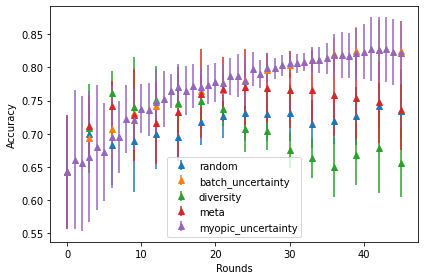

In [1121]:
# Run simulations of the above three methods with an initial set of five random instances.  
# Select instances in batches of three and run until 50% of instances have been observed.  
# In a single plot, show the classification accuracy (and standard deviation across seeds) 
# on the unobserved set as a function of the number of instances observed for all methods you 
# developed as well as random selection from Homework 0 across 10 simulations each.  
# Also include 10 simulations of myopic uncertainty sampling in your plot. -- ask
# Comment on the differences in performance between each method.
NUM_SIMS = 10
# "uncertainty",
# "m_uncertain",
#TYPE_ls = ["random", "uncertainty", "diversity", "meta"]
TYPE_ls =  ["random", "batch_uncertainty", "diversity", "meta", "myopic_uncertainty"]
classification_data =np.loadtxt(open("classification.csv", "rb"), delimiter=",", skiprows=1)
simulations(NUM_SIMS, classification_data, TYPE_ls)

1a.  Starting from your code base from Homework 0 and the classification task, implement a greedy batch-wise selection criteria using uncertainty sampling for your chosen base learner.  Your batch size should be 3 and you should select the three most uncertain instances for observation.

No description needed.-- This is the uncertainty sampling method I used for HW0 and HW1 and it seesm to do quite well, being the simple to implement least confident method. Specifically I use the 3 most uncertain points for each batch, with no correction for redundancy.

1b.  Starting from your code base from Homework 0 and the classification task, implement a batch-wise diversity-based sampling method. In no more than a few sentences, describe how you estimated batch diversity in your selection method.

For my batch diversity method I simply do a k means clustering at each step and take one datapoint from each cluster. To be precise, for each batch of 3, I do a k=3 means clustering and sample one point from each label class. 

1c.  Starting from your code base from Homework 0 and the classification task, implement a batch-wise meta-learning strategy from Lecture 13.  
No description needed.-- My meta learner is very simple: I do a k means clustering at each step and take the most uncertain datapoint from each cluster. Specifically, for each batch of 3, I do a k=3 means clustering and sample the most uncertain point from each label class. 

1d.  Run simulations of the above three methods with an initial set of five random instances.  Select instances in batches of three and run until 50% of instances have been observed.  In a single plot, show the classification accuracy (and standard deviation across seeds) on the unobserved set as a function of the number of instances observed for all methods you developed as well as random selection from Homework 0 across 10 simulations each.  Also include 10 simulations of myopic uncertainty sampling in your plot.  Comment on the differences in performance between each method. 

My myopic uncertainty and batch uncertainty methods perform almost exactly the same, with the batch uncertainty method perhaps starting better and having more variance. However even this is hard to tell. For all intents and purposes the two are pretty much the same. Diversity does quite well in the beginning but declines quickly in perforamce as the cluster become less and less informative, eventually becoming the only method to do significantly worse than random. Meta learning seems to balance between the slow but steady excellence of uncertainty, and the intially excellent but eventually terrible performance of diversity. Again, the clusters seem to be informative in the beginning and then quickly lose relevance. All in all, the uncertainty methods seem to be the best, meta is better than random, and diversity is worse than random.

94
52
94


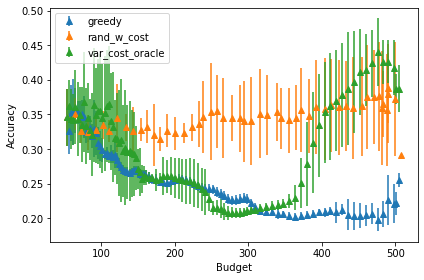

In [147]:

# Run 10 simulations with a max budget of 500 (~25% of full budget) for each selection method from 2a and 2b.  
# Also run a simulation with random selection. (Clarifying update 4/12/2022: 
# The random simulation will ignore cost, but be assessed based on the costs it incurred through random selection.  
# All of the simulations should start out with a random selection of 5 instances.)  Terminate your simulations when they have used up the budget.  
# Plot the resulting classification accuracy as a function of budget expenditures. 

#  be sure that all simulations above are using the same base learner

# Your simulations should use the same methods for initialization and the initial set should be included in the budget expenditures. 
# This eliminates any potential bias in your results caused by different initialization sets.  
# To check this in your results, look for all your simulations to have the same average and standard deviation of accuracy in the first round.  
NUM_SIMS = 10

TYPE_ls =  ["greedy", "rand_w_cost", "var_cost_oracle"] # "rand_w_cost", "var_cost_oracle", "greedy"
classification_data =np.loadtxt(open("classification2.csv", "rb"), delimiter=",", skiprows=1)[:, :4]
#print(classification_data[:,3].shape)
simulations(NUM_SIMS, classification_data, TYPE_ls, cost=True)

2a. Modify your classification simulations to take into account cost using “classifcation2.csv   Download classifcation2.csv ” as your dataset.  Implement a cost-based selection method similar to Proactive Learning Scenario 3 (Lecture 14).  Your selection method is allowed to see the costs while making selections so there is no need to try to estimate costs. (Clarifying update 4/12/2022: Lecture 14 refers to a constant cost oracle and a variable cost oracle.  You only need to implement the variable cost oracle.  The cost of an instance is determined based on what is in the cost column of that instance on the spreadsheet.)

No description needed. -- I implemented the oracle exactly as the utility function was described, using my uncertainty metric as the value function and the cost of the datapoint from the data as the cost function. 

2b.  For comparison, generate a selection method that will choose the least costly instance for observation (flip a coin to break ties).   

No description needed. -- I implemented a function that simply chooses the argmin of the datapoints wrt cost, it should resolve "coin tosses" automatically. 

2c. Run 10 simulations with a max budget of 500 (~25% of full budget) for each selection method from 2a and 2b.  Also run a simulation with random selection. (Clarifying update 4/12/2022: The random simulation will ignore cost, but be assessed based on the costs it incurred through random selection.  All of the simulations should start out with a random selection of 5 instances.)  Terminate your simulations when they have used up the budget.  Plot the resulting classification accuracy as a function of budget expenditures.  

No description needed. -- nothing to add here

2d.  Comment on the differences between the performance of the selection strategies.

Greedy seems to do the worst, quickly performing much worse than random and staying there. The variable cost oracle does just as bad as greedy at first, but then seems to get more and more influenced from the uncertainty component of its utility function, eventually doing  better than random. 


53
95


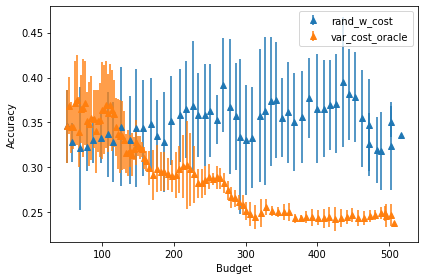

In [1110]:
#np.savetxt('better_for_random30.csv', classification_data, delimiter=",")
# 28, 24, 22 is good for random --28 is best
# 10,13 is excellent good for oracle -- 10 seems best
# not fully deterministic!! -- some runs will be worse than others, but the general trend seems constant
classification_data =np.loadtxt(open("better_for_random28.csv", "rb"), delimiter=",")
NUM_SIMS = 10
TYPE_ls =  ["rand_w_cost", "var_cost_oracle"] # "rand_w_cost", "var_cost_oracle", "greedy"
simulations(NUM_SIMS, classification_data, TYPE_ls, cost=True)

51
94


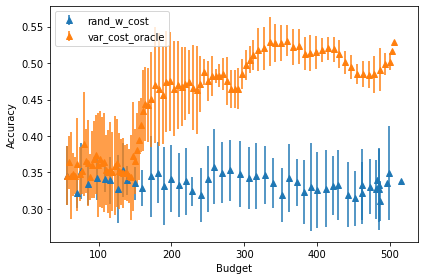

In [1124]:
classification_data =np.loadtxt(open("better_for_oracle10.csv", "rb"), delimiter=",")
NUM_SIMS = 10
TYPE_ls =  ["rand_w_cost", "var_cost_oracle"] # "rand_w_cost", "var_cost_oracle", "greedy"
simulations(NUM_SIMS, classification_data, TYPE_ls, cost=True)

3a.  Starting from “Classification2.csv”, generate two new datasets by reassigning the costs to different instances (the histogram of costs should be the same for the original dataset and the new reassigned datasets, because to generate each dataset you're only shuffling the cost column in the spreadsheet.).  One of your datasets should yield better than random performance with your cost sensitive selection strategy in 2a.  The other should yield worse than random performance using the same selection strategy.  Show the same sort of plots as in Part 2.

No description needed-- honestly I just implemented the utility function verbatim from the slides                                                                                                                     
                                                                                                                     
3b.  Comment on the differences in the datasets and why you think those differences contributed to differences in learning performance.
                                                                                                                     
It's pretty straightforward: if the cheapest points are close to the decision boundary then the variable cost oracle is better, if the most expensive points are by the decision boundary then random is better. In general it is much harder to get a dataset where random is better than the variable cost oracle consistently, as even if there a few cheap points that are marginally informative then variable cost oracle will do better, at least for a little while.                                                                                                                 
                                                                                                                     

TAs:
    
You can skip the rest of these cells, this is simply me confirming that if I keep the cheapest points close to the decision boundary then the variable cost oracle is better, and that if I put the most expensive points close to the decision boundary then random is better. I had to scrap this as it was not what was wanted for question 3 because I was creating new datapoints. However I wanted to leave it in to illustrate my thought process.

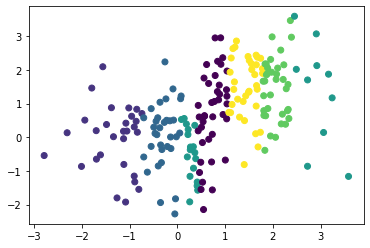

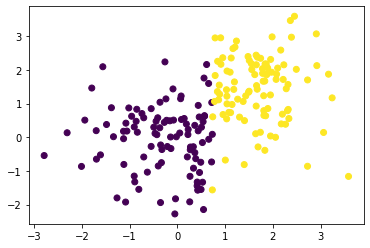

49
94


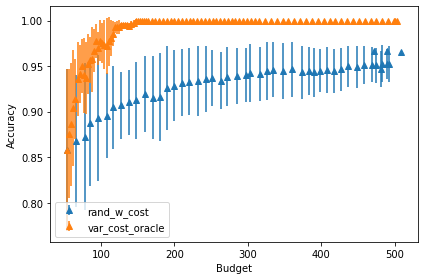

In [188]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.datasets import make_blobs

classification_data =np.loadtxt(open("classification2.csv", "rb"), delimiter=",", skiprows=1)[:, :4]
x_1 = list(np.random.normal(0, 1, 100)) + list(np.random.normal(1.4, 1, 100))
x_2 = list(np.random.normal(0, 1, 100)) + list(np.random.normal(1.4, 1, 100))
x_1 = (np.sort(x_1))
y = (100*[0]) +(100*[1])
#y = (80*[0]) +2*[0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,0,1,0,1,0] + (80*[1])

top_cost = (np.sort(classification_data[:, 3]))[40:]
low_cost = (np.sort(classification_data[:, 3]))[:40]
first = list(top_cost[:80])
second = list(top_cost[80:])
second.reverse()
#print(list(low_cost[75:]))
cost = first + list(low_cost) + second
#print(cost)
plt.scatter(x_1, x_2, c=cost)
plt.show()
plt.scatter(x_1, x_2, c=y)
plt.show()

y = np.reshape(y, (200, 1))
data = np.column_stack((x_1, x_2,y,cost))

NUM_SIMS = 10
TYPE_ls =  ["rand_w_cost", "var_cost_oracle"] # "rand_w_cost", "var_cost_oracle", "greedy"
simulations(NUM_SIMS, data, TYPE_ls, cost=True)

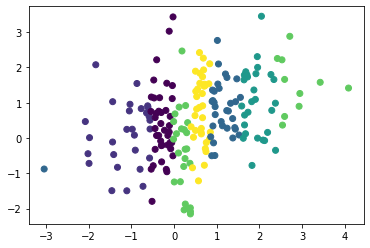

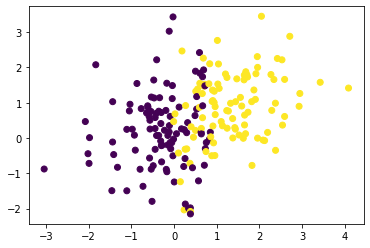

(200, 4)
51
95


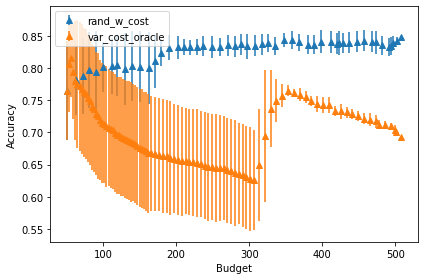

In [189]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.datasets import make_blobs

classification_data =np.loadtxt(open("classification2.csv", "rb"), delimiter=",", skiprows=1)[:, :4]
#print((classification_data[:, 3]))
x_1 = list(np.random.normal(0, 1, 100)) + list(np.random.normal(1, 1, 100))
x_2 = list(np.random.normal(0, 1, 100)) + list(np.random.normal(1, 1, 100))
# put the highest cost points in the center 
x_1 = (np.sort(x_1))

y = (70*[0]) +3*[0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,0,1,0,1,0] + (70*[1])
#y = (100*[0]) +(100*[1])

top_cost = (np.sort(classification_data[:, 3]))[140:]
low_cost = (np.sort(classification_data[:, 3]))[:140]
first = list(low_cost[:70])
second = list(low_cost[70:])
first.reverse()
cost = first + list(top_cost) + second

plt.scatter(x_1, x_2, c=cost)
plt.show()
plt.scatter(x_1, x_2, c=y)
plt.show()

y = np.reshape(y, (200, 1))
data = np.column_stack((x_1, x_2,y,cost))
print(data.shape)
NUM_SIMS = 10
TYPE_ls =  ["rand_w_cost", "var_cost_oracle"] # "rand_w_cost", "var_cost_oracle", "greedy"
simulations(NUM_SIMS, data, TYPE_ls, cost=True)